

# DATA 612 PROJECT 3
## Comparative SVD Study for Movie Recommendations






*   Farhod Ibragimov
*   Gillian McGovern

## Introduction

This project delves into matrix factorization for recommender systems, specifically SVD. Looking at the MovieLens dataset, multiple ratings for movies can represent the same overall interest from a user. By focusing on the film taste of users as opposed individual ratings, SVD (Singular Vector Decomposition) enables useful dimension reduction.

We will investigate the different ways to approach SVD:

*   Caclculations model
*   SciPy's `svds`
*   NumPy's `svd`





## SVD Calculations Model

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Create a results dictionary for model comparision at the end
results = {'model': [], 'predicted_rating': [], 'rmse': []}

In [ ]:
# Read in ratings data
url = "https://files.grouplens.org/datasets/movielens/ml-100k/u.data"
columns = ["user_id", "movie_id", "rating", "timestamp"]
ratings = pd.read_csv(url, sep="\t", names=columns)

# Read in movie labels data
movie_cols = ["movie_id", "title", "release_date", "video_release_date", "IMDb_URL"] + \
             ["unknown", "Action", "Adventure", "Animation", "Children's", "Comedy", "Crime",
              "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", "Musical",
              "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"]
genre_cols = movie_cols[5:]

movies = pd.read_csv(
    "http://files.grouplens.org/datasets/movielens/ml-100k/u.item",
    sep="|", names=movie_cols, encoding="latin-1"
)[["movie_id", "title"] + genre_cols]

In [ ]:
ratings.head()

,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [ ]:
# Merge data frames so we have the movie title as part of the user movie ratings
ratings = pd.merge(ratings, movies, on="movie_id")

# Only focus on user_id, title, and rating
ratings = ratings[['user_id', 'title', 'rating']]

In [ ]:
display(f"Dataset's shape: {ratings.shape}")
display(f"Unique users: {ratings.user_id.nunique()}")
display(f"Unique movies: {ratings.title.nunique()}")
display(f"Rating sacale: {ratings.rating.unique()}")

"Dataset's shape: (100000, 3)"

'Unique users: 943'

'Unique movies: 1664'

'Rating sacale: [3 1 2 4 5]'

Focus on 200 most-active users & 100 most-rated movies

In [ ]:
top_users = ratings.user_id.value_counts().head(200).index.tolist()
top_movies = ratings.title.value_counts().head(100).index.tolist()

In [ ]:
ratings_subset = ratings[
    ratings.user_id.isin(top_users) &
    ratings.title.isin(top_movies)
]

In [ ]:
display(f"Dataset's subset shape: {ratings_subset.shape}")

"Dataset's subset shape: (12776, 3)"

In [ ]:
rating_matrix = ratings_subset.pivot_table(
    index="user_id",
    columns="title",
    values="rating"
)
#checking if all ratings are INT
display(rating_matrix.dtypes)
rating_matrix.applymap(type).nunique()

,0
title,
2001: A Space Odyssey (1968),float64
Air Force One (1997),float64
Aladdin (1992),float64
Alien (1979),float64
Aliens (1986),float64
...,...
"Usual Suspects, The (1995)",float64
Volcano (1997),float64
When Harry Met Sally... (1989),float64


/tmp/ipython-input-181-3476281195.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  rating_matrix.applymap(type).nunique()


,0
title,
2001: A Space Odyssey (1968),1
Air Force One (1997),1
Aladdin (1992),1
Alien (1979),1
Aliens (1986),1
...,...
"Usual Suspects, The (1995)",1
Volcano (1997),1
When Harry Met Sally... (1989),1


## Singular Value Decomposition SVD

Let $R$ be our mean-centered ratings matrix. Then the Singular Value Decomposition is:

$$
R = U \Sigma V^\top
$$

- $U$ contains the left singular vectors (user features)
- $\Sigma$ is the diagonal matrix of singular values
- $V^\top$ contains the right singular vectors (movie features)


In [ ]:
user_means = rating_matrix.mean(axis=1)
R_centered_df = rating_matrix.sub(user_means, axis=0)
R_centered = R_centered_df.fillna(0).values

In [ ]:
print("R_centered shape", R_centered.shape)
print(f"User mean {user_means[:5]}")
print(R_centered[:2,:5])

R_centered shape (200, 100)
User mean user_id
1     4.115942
5     3.694444
6     3.531250
7     4.278481
10    4.352941
dtype: float64
[[-0.1159  0.     -0.1159  0.8841  0.8841]
 [ 0.3056  0.      0.3056  0.3056 -0.6944]]


## Compute $R^\top R$
This is the movie-movie covariance matrix, and here we find eigenvectors in the movie's (columns) space

In [ ]:
RtR = R_centered.T @ R_centered
display("RtR shape", RtR.shape)
display(RtR)

'RtR shape'

(100, 100)

array([[137.2938, -21.813 , -12.9239, ..., -11.1502,   2.4733,  17.2382],
       [-21.813 ,  93.222 ,   1.2035, ...,  -5.6912, -14.7959,  -9.7247],
       [-12.9239,   1.2035,  82.1452, ...,  10.3122,   4.2026,  -2.3346],
       ...,
       [-11.1502,  -5.6912,  10.3122, ..., 111.2863,  -4.1638,  -1.7321],
       [  2.4733, -14.7959,   4.2026, ...,  -4.1638, 139.0943,   7.2457],
       [ 17.2382,  -9.7247,  -2.3346, ...,  -1.7321,   7.2457,  94.1229]])

In [ ]:
eigvals_V, V = np.linalg.eigh(RtR)

Here we sort the eigenvalues and reorder the columns of
𝑉
 to match

Each column of
𝑉
 is a right singular vector (movie latent feature)

In [ ]:
idx = np.argsort(eigvals_V)[::1]
eigvals_V= eigvals_V[idx]
V = V[:, idx]

In [ ]:
np.set_printoptions(suppress=True, precision=4)
print("Top 5 eigenvalues:", eigvals_V[:5])

Top 5 eigenvalues: [ 0.      7.4272  8.6692  9.2638 11.1561]


## Computing singular values from eigenvalues


In [ ]:
eigvals_V_clipped = np.clip(eigvals_V, a_min=0, a_max=None)

singular_values = np.sqrt(eigvals_V_clipped)
print("top 5 singular values", singular_values[:5])

top 5 singular values [0.     2.7253 2.9443 3.0436 3.3401]


##  $\Sigma$ sigma diagonal matrix

In [ ]:
Sigma = np.diag(singular_values)
print("Sigma's shape: ", Sigma.shape)
print(singular_values)

Sigma's shape:  (100, 100)
[ 0.      2.7253  2.9443  3.0436  3.3401  3.356   3.4585  3.4805  3.5451
  3.6734  3.7845  3.9496  4.0234  4.1387  4.2581  4.3906  4.4803  4.6361
  4.7697  4.7888  4.921   5.0595  5.1608  5.3259  5.3734  5.46    5.6338
  5.8227  5.9906  6.0857  6.1     6.1804  6.2792  6.4269  6.54    6.6506
  6.7941  6.9438  6.9554  7.041   7.1783  7.285   7.4529  7.4726  7.5369
  7.882   7.9759  8.045   8.2576  8.3661  8.3793  8.5864  8.6723  8.7238
  9.0187  9.1788  9.4461  9.5704  9.7239  9.8786  9.9187 10.0972 10.2472
 10.2758 10.3336 10.5868 10.6595 10.8204 10.9177 10.9664 11.0808 11.258
 11.3722 11.6095 11.8993 12.01   12.2912 12.4979 12.5385 12.8388 13.053
 13.2218 13.4318 13.545  13.6497 13.9642 14.3882 14.5563 14.5718 14.7924
 15.4547 15.6573 15.9604 16.602  16.9074 17.6703 18.3229 19.0641 24.5951
 37.0062]


## Now we compute $U$ matrix of user feature vectors.
We compute the left singular vectors matrix $U$ using:

$$
U_i = \frac{1}{\sigma_i} R V_i
$$

This means each column $U_i$ of $U$ is computed by projecting the data matrix $R$ onto the corresponding right singular vector $V_i$, and then scaling by the inverse of the singular value $\sigma_i$.

To compute the full matrix $U_k$ for the top-$k$ components:

$$
U_k = R V_k \Sigma_k^{-1}
$$

Where:

- $R$ is the mean-centered ratings matrix
- $V_k$ is the matrix of the top-$k$ right singular vectors
- $\Sigma_k^{-1}$ is the inverse of the diagonal matrix of the top-$k$ singular values

We’ll do it line-by-line and only for top 20 k components , because we don’t want to compute weak or noisy directions.


In [ ]:
valid_idx = singular_values > 1e-6
k = 50

# This gives the actual numeric values
singular_values_k = singular_values[valid_idx][:k]

# Now build the diagonal matrices
Sigma_k = np.diag(singular_values_k)
Sigma_k_inv = np.diag(1 / singular_values_k)

Slicing top 20 right singular vectors $V$

In [ ]:
V_k = V[:, valid_idx][:, :k]

Each column in `V_k` is a latent feature in the movie space $V$



## Computing $\Sigma_k^{-1}$

In [ ]:
Sigma_k_inv = np.linalg.inv(Sigma_k)
print("Sigma_k_inv shape:", Sigma_k_inv.shape)
print("Diagonal entries of Sigma_k_inv:", np.diag(Sigma_k_inv))
print("Singular values used:", np.diag(Sigma_k))

Sigma_k_inv shape: (50, 50)
Diagonal entries of Sigma_k_inv: [0.3669 0.3396 0.3286 0.2994 0.298  0.2891 0.2873 0.2821 0.2722 0.2642
 0.2532 0.2485 0.2416 0.2348 0.2278 0.2232 0.2157 0.2097 0.2088 0.2032
 0.1976 0.1938 0.1878 0.1861 0.1832 0.1775 0.1717 0.1669 0.1643 0.1639
 0.1618 0.1593 0.1556 0.1529 0.1504 0.1472 0.144  0.1438 0.142  0.1393
 0.1373 0.1342 0.1338 0.1327 0.1269 0.1254 0.1243 0.1211 0.1195 0.1193]
Singular values used: [2.7253 2.9443 3.0436 3.3401 3.356  3.4585 3.4805 3.5451 3.6734 3.7845
 3.9496 4.0234 4.1387 4.2581 4.3906 4.4803 4.6361 4.7697 4.7888 4.921
 5.0595 5.1608 5.3259 5.3734 5.46   5.6338 5.8227 5.9906 6.0857 6.1
 6.1804 6.2792 6.4269 6.54   6.6506 6.7941 6.9438 6.9554 7.041  7.1783
 7.285  7.4529 7.4726 7.5369 7.882  7.9759 8.045  8.2576 8.3661 8.3793]


## Computing $U_k$

In [ ]:
U_k = R_centered @ V_k @ Sigma_k_inv

## Checking orthogonality

In [ ]:
np.allclose(U_k.T @ U_k, np.eye(k), atol=1e-1)
diff = U_k.T @ U_k - np.eye(k)
max_dev = np.abs(diff).max()
print(f"Max deviation from orthogonality: {max_dev:.10f}")


Max deviation from orthogonality: 0.0000000000


## Reconstructing the mean-centered ratings matrix


In [ ]:
R_hat_centered = U_k @ Sigma_k@V_k.T
print("reconstructed matric shape:", R_hat_centered.shape)

reconstructed matric shape: (200, 100)


## Adding back to user means

In [ ]:
user_means_array = user_means.values.reshape(-1, 1)
R_hat_final = R_hat_centered + user_means_array

## Calculating RMSE of predicted ratings vs original ratings

In [ ]:
original_ratings = rating_matrix.values
mask = ~np.isnan(original_ratings)
rmse = np.sqrt(np.mean((original_ratings[mask] - R_hat_final[mask])**2))
print(f"RMSE (k = {k} on known ratings: {rmse: 4f})")

RMSE (k = 50 on known ratings:  0.842826)


## Testing RMSE for k in range of 5 to 100

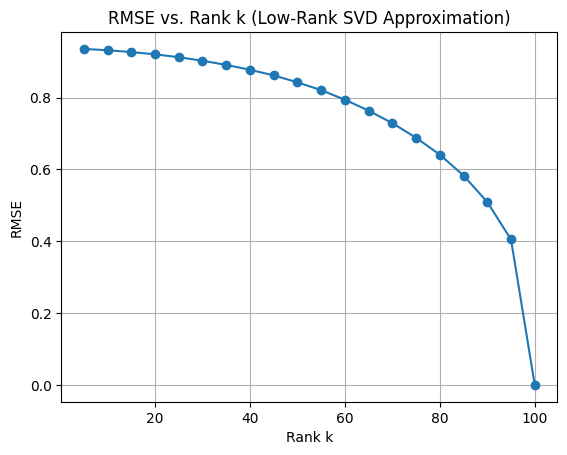

'Best number of rank k: 100 with RMSE of 1.4894996918940145e-15'

In [ ]:
rmse_values = []
k_values = range(5, 101, 5)

for k in k_values:
    singular_values_k = singular_values[valid_idx][:k]
    Sigma_k = np.diag(singular_values_k)
    Sigma_k_inv = np.diag(1 / singular_values_k)
    V_k = V[:, valid_idx][:, :k]
    U_k = R_centered @ V_k @ Sigma_k_inv
    R_hat_centered = U_k @ Sigma_k @ V_k.T
    R_hat_final = R_hat_centered + user_means_array
    rmse = np.sqrt(np.mean((original_ratings[mask] - R_hat_final[mask])**2))
    rmse_values.append(rmse)

# Plot
import matplotlib.pyplot as plt

plt.plot(k_values, rmse_values, marker='o')
plt.title("RMSE vs. Rank k (Low-Rank SVD Approximation)")
plt.xlabel("Rank k")
plt.ylabel("RMSE")
plt.grid(True)
plt.show()
display(f"Best number of rank k: {k_values[np.argmin(rmse_values)]} with RMSE of {np.min(rmse_values)}")

In [ ]:
# Add to our results dictionary
# For predicted rating value, focus on user 6 and Titanic
user_6 = rating_matrix.loc[[6]]
user_6.dropna(axis=1, inplace=True)
user_6_movie_list = user_6.columns.tolist()

calculated_ratings_df = pd.DataFrame(R_hat_final, index=rating_matrix.index, columns=rating_matrix.columns)

# Movies our recommender would suggest for user 6
calculated_ratings_user_6_v1 = calculated_ratings_df.loc[6,:].sort_values(ascending=False)
calculated_ratings_user_6_unique_v1_titanic = calculated_ratings_user_6_v1[calculated_ratings_user_6_v1.index == "Titanic (1997)"]

results['model'].append('Calculated Model')
results['predicted_rating'].append(float(calculated_ratings_user_6_unique_v1_titanic.iloc[0]))
results['rmse'].append(np.min(rmse_values))

## FunkSVD matrix factorization using Scotastic Gradient Descent SGD in details

The goal of FunkSVD is to approximate the user-item rating matrix $R$ by the product of two low-rank matrices:

$$
R \approx \hat{R} = U V^T
$$

Where:
- $U \in \mathbb{R}^{n \times k}$ is the user latent feature matrix  
- $V \in \mathbb{R}^{m \times k}$ is the item latent feature matrix  
- $k$ is the number of latent features

Each predicted rating is computed as:

$$
\hat{r}_{ui} = \mathbf{u}_u^\top \mathbf{v}_i = \sum_{f=1}^{k} u_{uf} \cdot v_{if}
$$


### Loss Function (MSE + Regularization)

We minimize the regularized mean squared error over all known entries:

$$
\mathcal{L} = \sum_{(u,i) \in \mathcal{K}} \left( r_{ui} - \hat{r}_{ui} \right)^2
+ \lambda \left( \|\mathbf{u}_u\|^2 + \|\mathbf{v}_i\|^2 \right)
$$

Where:
- $\mathcal{K}$ is the set of observed $(u, i)$ rating pairs  
- $\lambda$ is the regularization parameter

Here we build `funk_svd_from_fd` function to perform matrix factorization using Stochastic Gradient Descent (SGD).



In [ ]:
def funk_svd_with_bias(rating_df, k=20, lr=0.005, reg=0.02, epochs=20):
    # 1) ID maps
    users = rating_df.index.tolist()
    items = rating_df.columns.tolist()
    u_map = {u:i for i,u in enumerate(users)}
    i_map = {m:i for i,m in enumerate(items)}

    # 2) Build training triplets
    data = [
        (u_map[u], i_map[m], rating_df.at[u,m])
        for u in users for m in items
        if not pd.isna(rating_df.at[u,m])
    ]

    n_u, n_i = len(users), len(items)
    # 3) Initialize biases & latent factors
    μ  = np.nanmean(rating_df.values)      # global mean
    b_u = np.zeros(n_u)                    # user biases
    b_i = np.zeros(n_i)                    # item biases
    U   = np.random.normal(0, 0.01, (n_u, k))
    V   = np.random.normal(0, 0.01, (n_i, k))

    # 4) SGD loop
    for epoch in range(epochs):
        np.random.shuffle(data)
        sq_err = 0
        for u, m, r in data:
            # prediction = μ + user_bias + item_bias + dot-product
            pred = μ + b_u[u] + b_i[m] + U[u].dot(V[m])
            err  = r - pred

            # update biases
            b_u[u] += lr * (err - reg * b_u[u])
            b_i[m] += lr * (err - reg * b_i[m])
            # update latent factors
            U[u]   += lr * (err * V[m] - reg * U[u])
            V[m]   += lr * (err * U[u] - reg * V[m])

            sq_err += err**2

        rmse = np.sqrt(sq_err / len(data))
        print(f"Epoch {epoch+1:02d}: RMSE = {rmse:.4f}")

    # 5) Reconstruct full prediction matrix
    R_hat = μ + b_u[:,None] + b_i[None,:] + U.dot(V.T)

    # —————————————————————————————————————
    # Clip *once* with the true min/max (ignoring NaNs):
    min_rating = np.nanmin(rating_df.values)
    max_rating = np.nanmax(rating_df.values)
    R_hat = np.clip(R_hat, min_rating, max_rating)
    # —————————————————————————————————————

    pred_df = pd.DataFrame(R_hat, index=users, columns=items)
    return pred_df, U, V, b_u, b_i, rmse


In [ ]:
#print("Grouped shape:", ratings_subset_grouped.shape)
#print(ratings_subset_grouped.head(10))
ratings_subset_clean = ratings_subset.dropna(subset=['user_id', 'title', 'rating'])
print(ratings_subset_clean)
#ratings_subset_clean['user_id'] = pd.to_numeric(ratings_subset_clean['user_id'], errors='coerce')
#ratings_subset_clean['title'] = pd.to_numeric(ratings_subset_clean['title'], errors='coerce')  # if it's really an ID
#ratings_subset_clean['rating'] = pd.to_numeric(ratings_subset_clean['rating'], errors='coerce')
ratings_subset_clean = ratings_subset_clean.dropna(subset=['user_id', 'title', 'rating'])
print(ratings_subset_clean)
ratings_subset_grouped = ratings_subset_clean.groupby(['user_id', 'title'], as_index=False)['rating'].mean()
rating_matrix_FunkSVD = ratings_subset_grouped.pivot(index='user_id', columns='title', values='rating')
#print(rating_matrix_FunkSVD)

# Drop empty rows/columns just in case
rating_matrix_FunkSVD = rating_matrix_FunkSVD.dropna(how='all', axis=0)
rating_matrix_FunkSVD = rating_matrix_FunkSVD.dropna(how='all', axis=1)

print("Matrix shape:", rating_matrix_FunkSVD.shape)
print("Non-NaN ratings:", rating_matrix_FunkSVD.notna().sum().sum())


       user_id                             title  rating
10          62               Men in Black (1997)       2
12         200   Star Trek: First Contact (1996)       5
22         299                   Die Hard (1988)       4
23         291                    Twister (1996)       2
24         308                  Toy Story (1995)       4
...        ...                               ...     ...
99942      363         Return of the Jedi (1983)       5
99951      130     Independence Day (ID4) (1996)       5
99965      934    When Harry Met Sally... (1989)       1
99982      279  Shawshank Redemption, The (1994)       1
99996      716         Back to the Future (1985)       5

[12776 rows x 3 columns]
       user_id                             title  rating
10          62               Men in Black (1997)       2
12         200   Star Trek: First Contact (1996)       5
22         299                   Die Hard (1988)       4
23         291                    Twister (1996)       2
24   

### Training the FunkSVD Recommender

We now train the `funk_svd_from_df()` function on the user-item rating matrix using:

- **Latent dimensions (k)** = 70
- **Learning rate (η)** = 0.01
- **Regularization (λ)** = 0.02
- **Epochs** = 50

Each parameter is tunable, but with trade-offs. Increasing $k$ or lowering $\lambda$ might reduce RMSE, but at the cost of overfitting or longer computation time. There’s no universally optimal configuration—hyperparameter tuning must balance model complexity with generalization.

The model learns user and item latent vectors via SGD and reconstructs a full rating matrix. We also inspect the range of predicted values and verify the original rating scale.

In [ ]:
ratings_FunkSVD, U, V, b_u, b_i, funk_rmse = funk_svd_with_bias(
    rating_matrix_FunkSVD,
    k=70,
    lr=0.001,
    reg=0.02,
    epochs=50
)
print("Prediction range:", ratings_FunkSVD.values.min(), ratings_FunkSVD.values.max())
print("Original rating min/max:",
      ratings_subset['rating'].min(), ratings_subset['rating'].max())

print(ratings_subset.sample(5).T)
preds6 = ratings_FunkSVD.loc[6]
print(preds6.head(10))         # do you see floats or NaNs?
print("NaNs:", preds6.isna().sum(), "out of", len(preds6))


Epoch 01: RMSE = 1.0086
Epoch 02: RMSE = 0.9877
Epoch 03: RMSE = 0.9703
Epoch 04: RMSE = 0.9557
Epoch 05: RMSE = 0.9435
Epoch 06: RMSE = 0.9332
Epoch 07: RMSE = 0.9244
Epoch 08: RMSE = 0.9170
Epoch 09: RMSE = 0.9107
Epoch 10: RMSE = 0.9052
Epoch 11: RMSE = 0.9005
Epoch 12: RMSE = 0.8964
Epoch 13: RMSE = 0.8929
Epoch 14: RMSE = 0.8899
Epoch 15: RMSE = 0.8872
Epoch 16: RMSE = 0.8849
Epoch 17: RMSE = 0.8828
Epoch 18: RMSE = 0.8810
Epoch 19: RMSE = 0.8795
Epoch 20: RMSE = 0.8781
Epoch 21: RMSE = 0.8769
Epoch 22: RMSE = 0.8758
Epoch 23: RMSE = 0.8748
Epoch 24: RMSE = 0.8740
Epoch 25: RMSE = 0.8732
Epoch 26: RMSE = 0.8725
Epoch 27: RMSE = 0.8719
Epoch 28: RMSE = 0.8714
Epoch 29: RMSE = 0.8709
Epoch 30: RMSE = 0.8705
Epoch 31: RMSE = 0.8701
Epoch 32: RMSE = 0.8697
Epoch 33: RMSE = 0.8694
Epoch 34: RMSE = 0.8692
Epoch 35: RMSE = 0.8689
Epoch 36: RMSE = 0.8687
Epoch 37: RMSE = 0.8685
Epoch 38: RMSE = 0.8683
Epoch 39: RMSE = 0.8681
Epoch 40: RMSE = 0.8680
Epoch 41: RMSE = 0.8678
Epoch 42: RMSE =

Final training RMSE: **0.867**

Predicted ratings were clipped between 0 and 5. The prediction range and some sampled entries from the original rating data confirm consistency with the input domain.

Let's see what are predicted movies for user 6

In [ ]:
def recommendations_for_user(predictions_dataset, original_dataset, user_id, top_n):
    user_predictions = predictions_dataset.loc[user_id]
    rated_movies = original_dataset.loc[user_id].dropna().index

    unseen_predictions = user_predictions.drop(index=rated_movies)
    top_recommendations = unseen_predictions.sort_values(ascending=False).head(top_n)

    #print(f"\nTop {top_n} recommendations for user {user_id}:")
    #display(top_recommendations)

    return pd.DataFrame({
        "title": top_recommendations.index,
        "FunkSVD_predicted_rating": top_recommendations.values
    })

user_6_funkSVD_recommendations = recommendations_for_user(ratings_FunkSVD,
                         rating_matrix_FunkSVD,
                         user_id=6,
                         top_n=100)

user_6_funkSVD_recommendations.head(20)

,title,FunkSVD_predicted_rating
0,"Empire Strikes Back, The (1980)",3.820870
1,Titanic (1997),3.732805
2,Return of the Jedi (1983),3.653244
3,Terminator 2: Judgment Day (1991),3.582120
4,Aliens (1986),3.575342
5,"Clockwork Orange, A (1971)",3.574270
6,Dead Poets Society (1989),3.528014
7,"Hunt for Red October, The (1990)",3.493316
8,Indiana Jones and the Last Crusade (1989),3.489522
9,Stand by Me (1986),3.465935


In [ ]:
predicted_rating_titanic_funksvd = ratings_FunkSVD.loc[6, "Titanic (1997)"]
results['model'].append('FunkSVD')
results['predicted_rating'].append(predicted_rating_titanic_funksvd)
results['rmse'].append(funk_rmse)


## SVD Models Via Python Libraries

### SVD Model Using SciPy

One library to use for SVD is SciPy's `svds`. According to documentation, `svds` "compute[s] the largest or smallest k singular values and corresponding singular vectors of a sparse matrix."

In [ ]:
from scipy.sparse.linalg import svds
from sklearn.metrics import root_mean_squared_error

In [ ]:
# Use svds to find U, sigma, Vt
# svds will find the largest or smallest k singular values and corresponding singular vectors of a sparse matrix A
# The defualt is the largest
# Default k value = 6
U, sigma, Vt = svds(R_centered)

The default solver for `svds` is `arpack` which, according to ARPACK documentaion, "compute[s] a few eigenvalues and corresponding eigenvectors of large sparse or structured matrices, using the Implicitly Restarted Arnoldi Method (IRAM)".

Taking a quick look at the shape of `U`, we can see our k value as 6.

In [ ]:
display(U.shape)

(200, 6)

In [ ]:
# Sigma needs to be a diagonal matrix
sigma = np.diag(sigma)
display(sigma)

array([[16.9074,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
       [ 0.    , 17.6703,  0.    ,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    , 18.3229,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    , 19.0641,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    , 24.5951,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    , 37.0062]])

After calculating the dot product, we can see our final matrix below:

In [ ]:
# Perform the dot product
calculated_ratings = np.dot(np.dot(U, sigma), Vt)
# Add the means back
R_hat_final_v2 = calculated_ratings + user_means_array
R_hat_final_v2 = np.clip(R_hat_final_v2, 0, 5)
# Final matrix
display(R_hat_final_v2)

array([[4.4095, 3.7873, 3.8194, ..., 3.8098, 4.2483, 4.2575],
       [4.0941, 3.598 , 3.4058, ..., 3.2896, 3.7105, 3.7701],
       [4.4637, 3.1136, 3.0509, ..., 3.0806, 3.3268, 4.1952],
       ...,
       [3.9747, 3.0501, 3.2628, ..., 3.3498, 2.9827, 3.6337],
       [3.9451, 3.7484, 3.7705, ..., 3.7655, 3.6395, 3.7233],
       [3.9727, 3.8074, 4.1588, ..., 4.2932, 3.9996, 3.5935]])

Let's convert to a data frame:

In [ ]:
# Final calculated ratings data frame
calculated_ratings_df = pd.DataFrame(R_hat_final_v2, index=rating_matrix.index, columns=rating_matrix.columns)
calculated_ratings_df.head()

title,2001: A Space Odyssey (1968),Air Force One (1997),Aladdin (1992),Alien (1979),Aliens (1986),Amadeus (1984),Apocalypse Now (1979),Apollo 13 (1995),Babe (1995),Back to the Future (1985),...,Toy Story (1995),Trainspotting (1996),"Truth About Cats & Dogs, The (1996)",Twelve Monkeys (1995),Twister (1996),"Usual Suspects, The (1995)",Volcano (1997),When Harry Met Sally... (1989),Willy Wonka and the Chocolate Factory (1971),"Wizard of Oz, The (1939)"
user_id,,,,,,,,,,,,,,,,,,,,,
1,4.409481,3.787269,3.819393,4.750938,4.395500,4.393512,4.022891,4.159771,4.005191,4.330606,...,4.156993,3.722909,3.812494,4.184121,3.491740,4.627377,3.730137,3.809808,4.248260,4.257457
5,4.094145,3.598035,3.405834,4.178238,3.821282,3.776067,3.659814,3.650523,3.580361,3.798515,...,3.635556,3.441851,3.603951,3.741582,3.716189,3.841992,3.710131,3.289574,3.710478,3.770103
6,4.463748,3.113559,3.050899,4.304379,3.626964,4.318714,4.398970,3.468873,3.779669,3.271025,...,3.548788,3.849259,3.121167,3.560032,3.002830,4.043983,3.154271,3.080614,3.326793,4.195213
7,4.933761,3.915024,3.936492,4.813118,4.295770,4.837978,4.769667,4.336226,4.611565,4.432506,...,4.178371,4.014639,3.795532,4.355716,3.686475,4.898693,3.231558,4.119463,3.802736,4.653236
10,4.830041,4.258050,4.107147,4.656546,4.276579,4.670868,4.697600,4.355041,4.498619,4.354330,...,4.324162,4.296939,4.169104,4.325021,4.371536,4.476833,4.145905,4.093463,4.077809,4.660551


Let's compare against our original data frame:

In [ ]:
# Original calculated ratings data frame
rating_matrix.head()

title,2001: A Space Odyssey (1968),Air Force One (1997),Aladdin (1992),Alien (1979),Aliens (1986),Amadeus (1984),Apocalypse Now (1979),Apollo 13 (1995),Babe (1995),Back to the Future (1985),...,Toy Story (1995),Trainspotting (1996),"Truth About Cats & Dogs, The (1996)",Twelve Monkeys (1995),Twister (1996),"Usual Suspects, The (1995)",Volcano (1997),When Harry Met Sally... (1989),Willy Wonka and the Chocolate Factory (1971),"Wizard of Oz, The (1939)"
user_id,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,5.0,5.0,5.0,3.0,4.0,1.0,5.0,...,5.0,NaN,5.0,4.0,3.0,5.0,NaN,5.0,4.0,4.0
5,4.0,NaN,4.0,4.0,3.0,NaN,NaN,NaN,NaN,4.0,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,3.0,NaN
6,5.0,NaN,2.0,4.0,NaN,4.0,4.0,2.0,4.0,3.0,...,4.0,5.0,2.0,2.0,NaN,4.0,NaN,5.0,3.0,5.0
7,5.0,4.0,NaN,4.0,3.0,5.0,5.0,5.0,5.0,5.0,...,NaN,NaN,NaN,5.0,2.0,5.0,3.0,4.0,4.0,5.0
10,5.0,NaN,NaN,5.0,4.0,5.0,5.0,NaN,NaN,NaN,...,4.0,4.0,NaN,4.0,NaN,5.0,NaN,4.0,NaN,5.0


We can see the filled in missing values which is great, but some of the calculated ratings could be closer to the actual ones. Let's see what the RMSE shows:

In [ ]:
# Calculate the RMSE
rmse_v2 = root_mean_squared_error(original_ratings[mask], R_hat_final_v2[mask])
print(f"RMSE k = 6 on known ratings: {rmse_v2: 4f})")

RMSE k = 6 on known ratings:  0.754741)


A high RMSE of 0.76 makes sense here since even a small subset of the data showed us inaccurate results. We only used the default number of latent features value of 6, so let's test how the RMSE changes with varying number of latent features (k value).

#### Testing RMSE for different k values

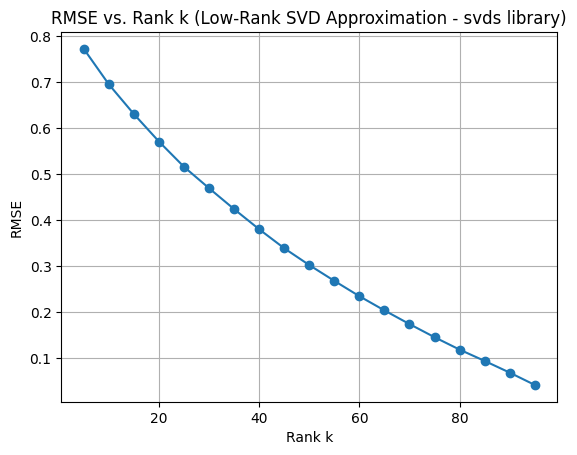

'Best number of rank k: 95 with RMSE of 0.04198128951000231'

In [ ]:
rmse_values_v2 = []
# `k` must be an integer satisfying `0 < k < min(R_centered.shape)`
k_values_v2 = range(5, 100, 5)

def find_svds_matrix_and_rmse(R_centered, k, original_ratings, user_means_array):
  """
  Returns the SciPy SVD matrix and RMSE
  """
  # This code is the same as above
  U, sigma, Vt = svds(R_centered, k=k)
  sigma = np.diag(sigma)
  calculated_ratings = np.dot(np.dot(U, sigma), Vt)
  R_hat_final = calculated_ratings + user_means_array
  rmse = root_mean_squared_error(original_ratings[mask], R_hat_final[mask])
  return R_hat_final, rmse

# Find RMSE for different k values
for k in k_values_v2:
  R_hat_final, rmse = find_svds_matrix_and_rmse(R_centered, k, original_ratings, user_means_array)
  rmse_values_v2.append(rmse)

# Plot
plt.plot(k_values_v2, rmse_values_v2, marker='o')
plt.title("RMSE vs. Rank k (Low-Rank SVD Approximation - svds library)")
plt.xlabel("Rank k")
plt.ylabel("RMSE")
plt.grid(True)
plt.show()

display(f"Best number of rank k: {k_values_v2[np.argmin(rmse_values_v2)]} with RMSE of {np.min(rmse_values_v2)}")

We can see here that as the number of latent features decreases, so does the RMSE. We saw this with our calculated model as well, but overall the calculated model had slightly higher RMSE values. 95 latent features produced the lowest RMSE value of `0.04` here.

#### Make a Prediction

Now let's try to make a prediction for user 6 using k=70:

In [ ]:
# Use k=70
R_hat_final, rmse = find_svds_matrix_and_rmse(R_centered, 70, original_ratings, user_means_array)
# Set predictions to be limited within the range of 0 and 5
R_hat_final_limited = np.clip(R_hat_final, 0, 5)
calculated_ratings_df = pd.DataFrame(R_hat_final_limited, index=rating_matrix.index, columns=rating_matrix.columns)

# Movies our recommender would suggest for user 6
calculated_ratings_user_6 = calculated_ratings_df.loc[6,:].sort_values(ascending=False)

# Find the movies user 6 has seen already
user_6 = rating_matrix.loc[[6]]
user_6.dropna(axis=1, inplace=True)
user_6_movie_list = user_6.columns.tolist()

# Find recommended unseen movies
calculated_ratings_user_6_unique = calculated_ratings_user_6[~calculated_ratings_user_6.index.isin(user_6_movie_list)]

# Add to our results dictionary
results['model'].append('SciPy')
results['predicted_rating'].append(float(calculated_ratings_user_6_unique.iloc[2]))
results['rmse'].append(min(rmse_values_v2))

# Display recommended movies
calculated_ratings_user_6_unique.head(20)

,6
title,
"Game, The (1997)",3.870712
Dante's Peak (1997),3.827942
Titanic (1997),3.814320
Top Gun (1986),3.784897
Terminator 2: Judgment Day (1991),3.746678
Ransom (1996),3.715087
Dead Poets Society (1989),3.715004
Indiana Jones and the Last Crusade (1989),3.657189
"Birdcage, The (1996)",3.643335


User 6's recommended movies does have a theme as most seem to have been made in the late 90's (at least the ones in the top 10). This does seem to focus on a wide genre of movies, which is good, because we want to focus on interests here, and not get recommened movies all in the same movie category.

Comparison:

In [ ]:
# Calculated matrix
calculated_ratings_df.head()

title,2001: A Space Odyssey (1968),Air Force One (1997),Aladdin (1992),Alien (1979),Aliens (1986),Amadeus (1984),Apocalypse Now (1979),Apollo 13 (1995),Babe (1995),Back to the Future (1985),...,Toy Story (1995),Trainspotting (1996),"Truth About Cats & Dogs, The (1996)",Twelve Monkeys (1995),Twister (1996),"Usual Suspects, The (1995)",Volcano (1997),When Harry Met Sally... (1989),Willy Wonka and the Chocolate Factory (1971),"Wizard of Oz, The (1939)"
user_id,,,,,,,,,,,,,,,,,,,,,
1,3.933622,4.065330,4.188824,4.971074,5.000000,4.678076,3.155949,4.153810,0.967801,4.869051,...,5.000000,4.031402,4.882309,4.132729,3.063548,4.715338,3.928965,4.863137,4.071980,4.212042
5,4.121434,3.313730,4.054011,3.907723,3.301629,3.621604,3.716367,3.854572,3.658845,4.147219,...,3.855023,3.873394,3.986378,3.629323,3.881759,3.627278,3.554883,1.034918,2.837680,3.595122
6,4.738060,3.249634,1.997049,4.156233,3.595434,3.899447,4.300732,2.201771,4.035422,3.293920,...,3.664252,4.875458,1.972893,2.300611,3.471892,4.075798,3.602792,4.843102,3.132176,5.000000
7,4.931308,4.095044,4.246428,3.890121,3.217126,4.660123,5.000000,5.000000,5.000000,5.000000,...,4.278103,4.184907,4.349509,5.000000,1.996352,4.665441,3.032729,4.117794,4.152047,4.948088
10,5.000000,4.548386,4.418846,4.785992,3.937142,4.874411,4.993742,4.392437,4.395889,4.016239,...,4.032756,4.045387,4.529352,3.987684,4.363017,4.627268,4.288657,4.134364,4.233390,5.000000


In [ ]:
# Original matrix
rating_matrix.head()

title,2001: A Space Odyssey (1968),Air Force One (1997),Aladdin (1992),Alien (1979),Aliens (1986),Amadeus (1984),Apocalypse Now (1979),Apollo 13 (1995),Babe (1995),Back to the Future (1985),...,Toy Story (1995),Trainspotting (1996),"Truth About Cats & Dogs, The (1996)",Twelve Monkeys (1995),Twister (1996),"Usual Suspects, The (1995)",Volcano (1997),When Harry Met Sally... (1989),Willy Wonka and the Chocolate Factory (1971),"Wizard of Oz, The (1939)"
user_id,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,5.0,5.0,5.0,3.0,4.0,1.0,5.0,...,5.0,NaN,5.0,4.0,3.0,5.0,NaN,5.0,4.0,4.0
5,4.0,NaN,4.0,4.0,3.0,NaN,NaN,NaN,NaN,4.0,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,3.0,NaN
6,5.0,NaN,2.0,4.0,NaN,4.0,4.0,2.0,4.0,3.0,...,4.0,5.0,2.0,2.0,NaN,4.0,NaN,5.0,3.0,5.0
7,5.0,4.0,NaN,4.0,3.0,5.0,5.0,5.0,5.0,5.0,...,NaN,NaN,NaN,5.0,2.0,5.0,3.0,4.0,4.0,5.0
10,5.0,NaN,NaN,5.0,4.0,5.0,5.0,NaN,NaN,NaN,...,4.0,4.0,NaN,4.0,NaN,5.0,NaN,4.0,NaN,5.0


This calculated matrix looks much more similar to the original matrix compared to when we used the default value of k=6.

### SVD Model Using NumPy

Another popular library to use is NumPy's `svd` function. According to the documentation, this function `factorize[s] a 2D array as u @ np.diag(s) @ vh = (u * s) @ vh, where u and the Hermitian transpose of vh are 2D arrays with orthonormal columns and s is a 1D array of a’s singular values` (with full_matrices=False).`

`The decomposition is performed using LAPACK routine _gesdd.`

In [ ]:
import numpy as np

Here we grab first 70 components of matrices

In [ ]:
# Need to set `full_matrices=False`: shapes will be (M, K) and (K, N), where K = min(M, N) (K=70)
# Otherwise, shapes will be (M, M) and (N,N )
U_v3, sigma_v3, Vt_v3 = np.linalg.svd(R_centered, full_matrices=False)
k = 70
# Update with latent features
U_v3     = U_v3[:, :k]        # shape (M, 70)
sigma_v3 = sigma_v3[:k]       # length-70 vector
Vt_v3    = Vt_v3[:k, :]       # shape (70, N)

In [ ]:
# View the resulting shape
U_v3.shape

(200, 70)

In [ ]:
# Sigma needs to be a diagonal matrix
sigma_v3 = np.diag(sigma_v3)
display(sigma_v3)

array([[37.0062,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
       [ 0.    , 24.5951,  0.    , ...,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    , 19.0641, ...,  0.    ,  0.    ,  0.    ],
       ...,
       [ 0.    ,  0.    ,  0.    , ...,  6.2792,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    , ...,  0.    ,  6.1804,  0.    ],
       [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  6.1   ]])

We now have all the smaller matricies to compute the calculated ratings matrix:

In [ ]:
# Perform the dot product
calculated_ratings_v3 = np.dot(np.dot(U_v3, sigma_v3), Vt_v3)
# Add the means back
R_hat_final_v3 = calculated_ratings_v3 + user_means_array
# Final matrix
display(R_hat_final_v3)

array([[3.9336, 4.0653, 4.1888, ..., 4.8631, 4.072 , 4.212 ],
       [4.1214, 3.3137, 4.054 , ..., 1.0349, 2.8377, 3.5951],
       [4.7381, 3.2496, 1.997 , ..., 4.8431, 3.1322, 5.3464],
       ...,
       [3.964 , 3.4426, 3.136 , ..., 3.0232, 3.9783, 2.7205],
       [3.9835, 3.9628, 3.5159, ..., 1.2597, 3.1399, 3.8799],
       [4.1597, 4.2609, 3.9945, ..., 4.2031, 3.9556, 2.9775]])

In [ ]:
# Find the RMSE
rmse_v3 = root_mean_squared_error(original_ratings[mask], R_hat_final_v3[mask])
display(rmse_v3)

0.1743652079811327

The RMSE of NumPy's SVD model with k=70 is 0.1743652079811327 which is significantly lower than the previous model.

Comparison:

In [ ]:
calculated_ratings_df_v3 = pd.DataFrame(R_hat_final_v3, index=rating_matrix.index, columns=rating_matrix.columns)
calculated_ratings_df_v3.head()

title,2001: A Space Odyssey (1968),Air Force One (1997),Aladdin (1992),Alien (1979),Aliens (1986),Amadeus (1984),Apocalypse Now (1979),Apollo 13 (1995),Babe (1995),Back to the Future (1985),...,Toy Story (1995),Trainspotting (1996),"Truth About Cats & Dogs, The (1996)",Twelve Monkeys (1995),Twister (1996),"Usual Suspects, The (1995)",Volcano (1997),When Harry Met Sally... (1989),Willy Wonka and the Chocolate Factory (1971),"Wizard of Oz, The (1939)"
user_id,,,,,,,,,,,,,,,,,,,,,
1,3.933622,4.065330,4.188824,4.971074,5.156229,4.678076,3.155949,4.153810,0.967801,4.869051,...,5.159342,4.031402,4.882309,4.132729,3.063548,4.715338,3.928965,4.863137,4.071980,4.212042
5,4.121434,3.313730,4.054011,3.907723,3.301629,3.621604,3.716367,3.854572,3.658845,4.147219,...,3.855023,3.873394,3.986378,3.629323,3.881759,3.627278,3.554883,1.034918,2.837680,3.595122
6,4.738060,3.249634,1.997049,4.156233,3.595434,3.899447,4.300732,2.201771,4.035422,3.293920,...,3.664252,4.875458,1.972893,2.300611,3.471892,4.075798,3.602792,4.843102,3.132176,5.346379
7,4.931308,4.095044,4.246428,3.890121,3.217126,4.660123,5.153713,5.097066,5.189873,5.001080,...,4.278103,4.184907,4.349509,5.123425,1.996352,4.665441,3.032729,4.117794,4.152047,4.948088
10,5.072113,4.548386,4.418846,4.785992,3.937142,4.874411,4.993742,4.392437,4.395889,4.016239,...,4.032756,4.045387,4.529352,3.987684,4.363017,4.627268,4.288657,4.134364,4.233390,5.101496


#### Make a Prediction

In [ ]:
# Movies our recommender would suggest for user 6
calculated_ratings_user_6_v3 = calculated_ratings_df_v3.loc[6,:].sort_values(ascending=False)

# Find recommended unseen movies
calculated_ratings_user_6_unique_v3 = calculated_ratings_user_6_v3[~calculated_ratings_user_6_v3.index.isin(user_6_movie_list)]
calculated_ratings_user_6_unique_v3.head(20)

,6
title,
"Game, The (1997)",3.870712
Dante's Peak (1997),3.827942
Titanic (1997),3.814320
Top Gun (1986),3.784897
Terminator 2: Judgment Day (1991),3.746678
Ransom (1996),3.715087
Dead Poets Society (1989),3.715004
Indiana Jones and the Last Crusade (1989),3.657189
"Birdcage, The (1996)",3.643335


This recommended list a bit different from the previous one, but they share a lot of movies.

In [ ]:
# Add to our results dictionary
# For predicted rating value, focus on user 6 and Titanic
calculated_ratings_user_6_unique_v3_titanic = calculated_ratings_user_6_v3[calculated_ratings_user_6_v3.index == "Titanic (1997)"]

results['model'].append('NumPy')
results['predicted_rating'].append(float(calculated_ratings_user_6_unique_v3_titanic.iloc[0]))
results['rmse'].append(rmse_v3)

## Model Comparison

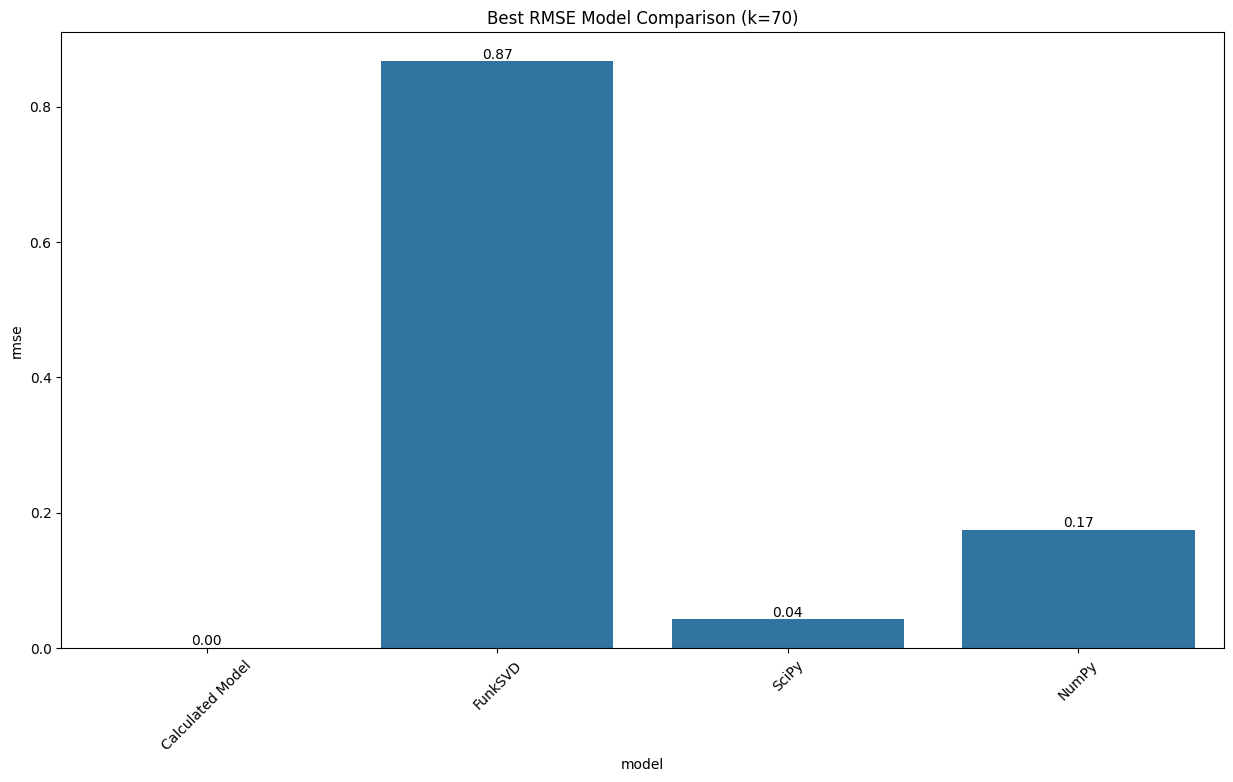

In [ ]:
# Plot the RMSE values for k=70 for each model
plt.figure(figsize=(15, 8))
ax = sns.barplot(x="model", y="rmse", data=results)
plt.title("Best RMSE Model Comparison (k=70)")
plt.xticks(rotation=45)

# Add labels above each bar
for i, bar in enumerate(ax.patches):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height ,
        f"{height:.2f}",
        ha='center',
        va='bottom'
    )


plt.show()

As we can see, FunkSVD has the highest RMSE, followed by NumPy and SciPy. The calculated model has the lowest RMSE value, so low that it doesn't even appear in our bar graph.

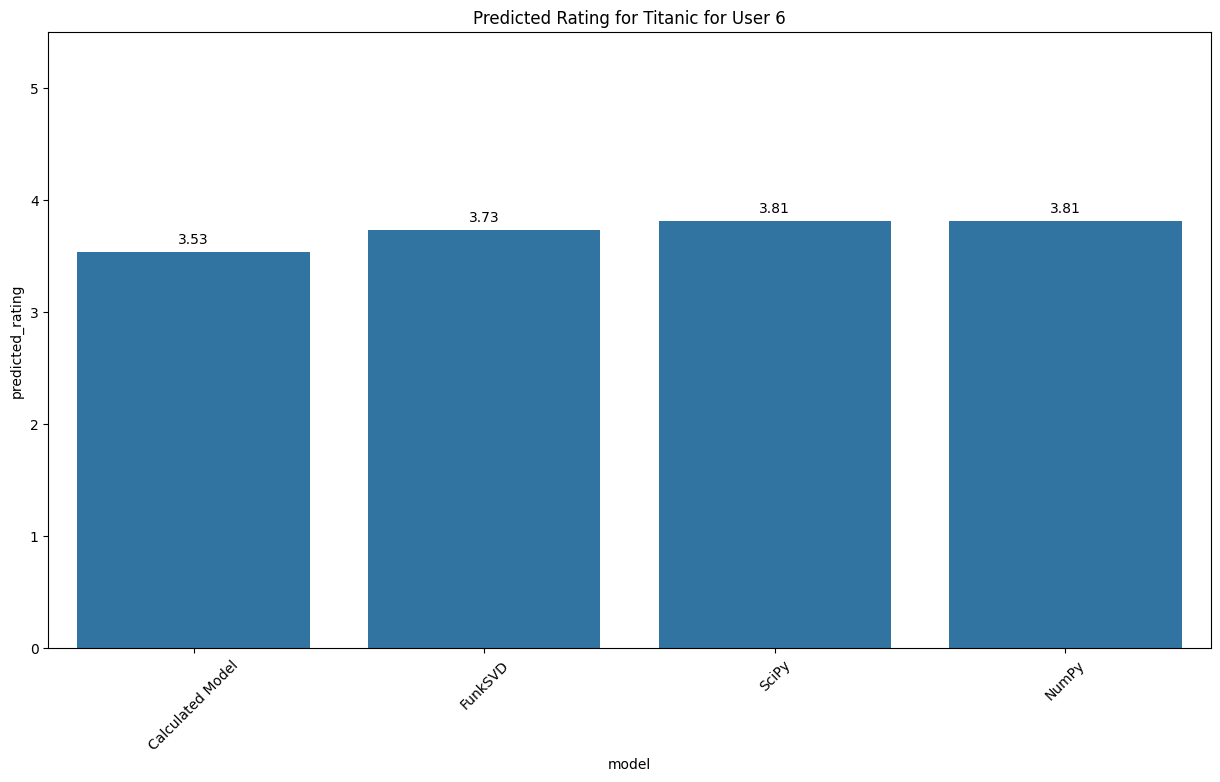

In [ ]:
# Plot the predicted rating for Titanic
plt.figure(figsize=(15, 8))
ax = sns.barplot(x="model", y="predicted_rating", data=results)
plt.title("Predicted Rating for Titanic for User 6")
plt.xticks(rotation=45)

# Add labels above each bar
for i, bar in enumerate(ax.patches):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.05,
        f"{height:.2f}",
        ha='center',
        va='bottom'
    )

plt.ylim(0, 5.5)
plt.show()

The predicted rating for Titanic is pretty much identical across all models.

Overall, all models predicted similar ratings with k=70. SciPy had the highest RMSE value, so in terms of picking a model, the calculated model or NumPy might be the best option. On the other hand, SciPy allows us to change k values, whereas NumPy does not have this option. You can get around this, but this requires extra steps. This means that runtime and storage would be the next factor to look into when trying to pick a model.

In [ ]:
from functools import reduce
print(type(calculated_ratings_user_6_unique))
print(type(calculated_ratings_user_6_unique_v3))
print(type(user_6_funkSVD_recommendations))
user6_recs_merged_df = reduce(lambda left,
                              right: pd.merge(left, right, on="title", how="outer"),
                              [calculated_ratings_user_6_unique, calculated_ratings_user_6_unique_v3,
                               user_6_funkSVD_recommendations])

user6_recs_merged_df.columns = [
    "title",
    "SciPy SVD model",
    "NumPy SVD model",
    "FunkSVD model"
]

display(user6_recs_merged_df)

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>


,title,SciPy SVD model,NumPy SVD model,FunkSVD model
0,Air Force One (1997),3.249634,3.249634,3.082673
1,Aliens (1986),3.595434,3.595434,3.575342
2,"Birdcage, The (1996)",3.643335,3.643335,2.864532
3,Broken Arrow (1996),3.511304,3.511304,2.572504
4,"Clockwork Orange, A (1971)",3.599943,3.599943,3.574270
5,Conspiracy Theory (1997),3.416539,3.416539,2.937633
6,Dances with Wolves (1990),3.587047,3.587047,3.311261
7,Dante's Peak (1997),3.827942,3.827942,2.496643
8,Dead Poets Society (1989),3.715004,3.715004,3.528014
9,"Devil's Own, The (1997)",3.359711,3.359711,2.541231


### SciPy vs. NumPy SVD
They both spit out the exact same “mean-centered echo” of our data at k=70 and gave us same results. We can use only one of these models.

### FunkSVD via SGD
FunkSVD vs. simple SVD

- **Bias terms** bump up popular hits and dampen flops instead of forcing every user/item onto the same mean.  
- **SGD on known ratings** means it learns from real feedback only, not the zeros we filled in for missing data.

## Conclusion

This project showed us the results for different SVD models using a subset of the MovieLens data. Some models give easier flexibility for model tuning, whereas other models produced a lower RMSE value.

Future Directions:


*   Record the run time for each model
*   Test with larger amounts of data

